In [1]:
import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from tqdm import trange
from torch.nn import functional as F
from utils.download_mnist import mnist_dataloader_test
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def experiment(config, x):
    ebm = make_energy_model(config, path=path)
    
    # The math
    x_tilde = ebm.operator(x)
    x_hat = ebm(x_tilde)
    
    # The result
    fig, axs = plt.subplots(nrows = 1, ncols = 2)
    axs[0].set_title("original")
    axs[0].imshow(plotable(x))
    axs[1].set_title("estimation")
    axs[1].imshow(plotable(x_hat))
    plt.show()

def reconstruction_error(x_hat, x, reduction="mean"):
    return F.mse_loss(x_hat, x, reduction=reduction)

In [53]:
model_name = "mnist/vae/langevin/inpainting"
config = get_model_config(model_name)
config["exp_params"]["batch_size"] = 100
dm = mnist_dataloader_test(config, path=path)

## Inpainting

### Posterior

In [54]:
config["estimator_params"]["initalisation"] = "posterior"

In [55]:
posterior = []
error_posterior = []
for num in trange(0, 16):
    config["operator_params"]["noise_level"] = num/15
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    posterior.append(e_x)
    error_posterior.append(std)

 94%|█████████▍| 15/16 [01:23<00:05,  5.60s/it]

### Map-posterior

In [ ]:
config["estimator_params"]["initalisation"] = "map_posterior"
config["estimator_params"]["num_steps_map_initaliser"] = 100
config["estimator_params"]["step_size_map_initaliser"] = 0.1

In [ ]:
map_posterior = []
error_map_posterior = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    map_posterior.append(e_x)
    error_map_posterior.append(std)

## Random

In [ ]:
config["estimator_params"]["initalisation"] = "random"

In [ ]:
random = []
error_random = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    random.append(e_x)
    error_random.append(std)

In [ ]:
error = []
for x, y in dm:
    x = x.to("cuda")
    error.append(reconstruction_error(torch.zeros_like(x), x))
baseline = (sum(error)/len(error)).cpu().detach()

In [ ]:
plt.xlabel('Number of measurements', fontsize=15)
plt.ylabel('Reconstruction error (per pixel)', fontsize=15)
plt.ylim(0, 0.15)
plt.plot(list(range(0, 750, 50)), [baseline]*15)
plt.errorbar(list(range(0, 750, 50)), random, yerr=error_random, fmt='-o')
plt.errorbar(list(range(0, 750, 50)), posterior, yerr=error_posterior, fmt='-^')
plt.errorbar(list(range(0, 750, 50)), map_posterior, yerr=error_map_posterior, fmt='-s')
plt.legend(['baseline (zero estimate)','random initalisation', 'map initalisation'])
plt.show()

## Compressed Sensing

In [38]:
config["operator_params"]["operator"] = "CompressedSensing"
config["operator_params"]["num_measurements"] = 200
config['estimator_params']['lambda'] = 1
config['estimator_params']['potential'] = "mse"
config["base_model_params"]["base_model"] = "vae"

### MAP-posterior

In [39]:
config["estimator_params"]["initalisation"] = "map_posterior"
config["estimator_params"]["num_steps_map_initaliser"] = 100
config["estimator_params"]["step_size_map_initaliser"] = 0.1

In [40]:
map_posterior = []
error_map_posterior = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    map_posterior.append(e_x)
    error_map_posterior.append(std)

100%|██████████| 15/15 [07:56<00:00, 31.74s/it]


### Random

In [36]:
config["estimator_params"]["initalisation"] = "random"

In [37]:
random = []
error_random = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    random.append(e_x)
    error_random.append(std)

100%|██████████| 15/15 [01:24<00:00,  5.62s/it]


In [30]:
error = []
for x, y in dm:
    x = x.to("cuda")
    error.append(reconstruction_error(torch.zeros_like(x), x))
baseline = (sum(error)/len(error)).cpu().detach()

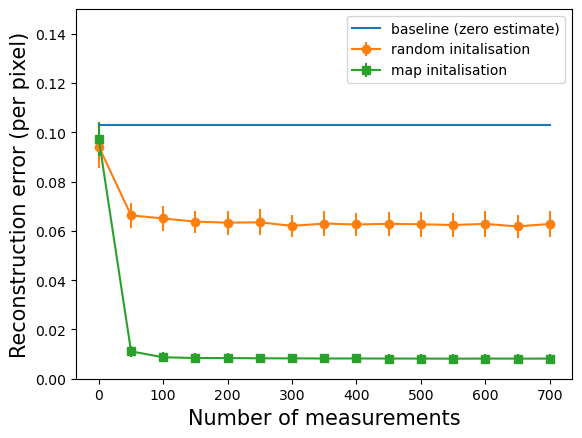

In [42]:
plt.xlabel('Number of measurements', fontsize=15)
plt.ylabel('Reconstruction error (per pixel)', fontsize=15)
plt.ylim(0, 0.15)
plt.plot(list(range(0, 750, 50)), [baseline]*15)
plt.errorbar(list(range(0, 750, 50)), random, yerr=error_random, fmt='-o')
plt.errorbar(list(range(0, 750, 50)), map_posterior, yerr=error_map_posterior, fmt='-s')
plt.legend(['baseline (zero estimate)','random initalisation', 'map initalisation'])
plt.show()

## Denoising

In [43]:
config["operator_params"]["operator"] = "GuassianNoise"
config["operator_params"]["noise_level"] = 0.5

### Random

In [44]:
config["estimator_params"]["initalisation"] = "random"

In [45]:
random = []
error_random = []
for num in trange(0, 16):
    config["operator_params"]["noise_level"] = num/15
    ebm = make_energy_model(config, path=path)
    emb = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    random.append(e_x)
    error_random.append(std)

100%|██████████| 16/16 [01:27<00:00,  5.49s/it]


### Posterior

In [46]:
config["estimator_params"]["initalisation"] = "posterior"

In [47]:
posterior = []
error_posterior = []
for num in trange(0, 16):
    config["operator_params"]["noise_level"] = num/15
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    posterior.append(e_x)
    error_posterior.append(std)

100%|██████████| 16/16 [01:29<00:00,  5.59s/it]


### MAP initalise

In [48]:
config["estimator_params"]["initalisation"] = "map_posterior"
config["estimator_params"]["num_steps_map_initaliser"] = 100
config["estimator_params"]["step_size_map_initaliser"] = 0.1

In [49]:
map_posterior = []
error_map_posterior = []
for num in trange(0, 16):
    config["operator_params"]["noise_level"] = num/15
    ebm = make_energy_model(config, path=path)
    ebm = make_energy_model(config, path=path)
    emb = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    map_posterior.append(e_x)
    error_map_posterior.append(std)

100%|██████████| 16/16 [08:13<00:00, 30.84s/it]


In [51]:
error = []
for x, y in dm:
    x = x.to("cuda")
    error.append(reconstruction_error(torch.zeros_like(x), x))
baseline = (sum(error)/len(error)).cpu().detach()

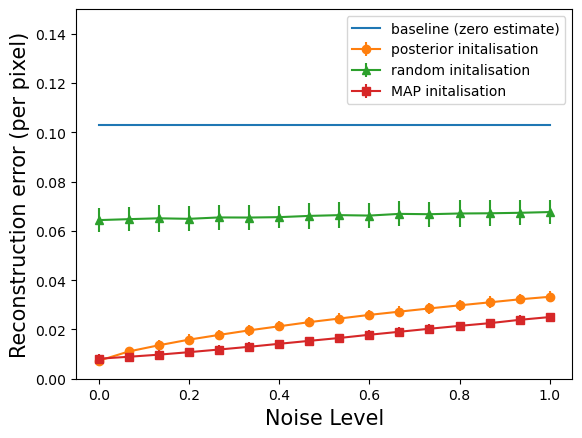

In [52]:
plt.xlabel('Noise Level', fontsize=15)
plt.ylabel('Reconstruction error (per pixel)', fontsize=15)
plt.ylim(0, 0.15)
noise = [i/15.0 for i in range(0, 16)]
plt.plot(noise, [baseline]*16)
plt.errorbar(noise, posterior, yerr=error_posterior, fmt='-o')
plt.errorbar(noise, random, yerr=error_random, fmt='-^')
plt.errorbar(noise, map_posterior, yerr=error_map_posterior, fmt='-s')
plt.legend(['baseline (zero estimate)','posterior initalisation', 'random initalisation', 'MAP initalisation'])
plt.show()